In [1]:
import os
import sys

import itertools
import pickle
import imageio
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

sys.path.append('../')
import utils
%matplotlib inline

In [2]:
root_folder = 'MNIST_VAE_results'
random_folder = root_folder + '/Random_results' 
fixed_folder = root_folder + '/Fixed_results'

if not os.path.isdir(root_folder):
    os.mkdir(root_folder)
if not os.path.isdir(fixed_folder):
    os.mkdir(fixed_folder)
if not os.path.isdir(random_folder):
    os.mkdir(random_folder)

In [3]:
lr = 0.001
prior_size = 10
batch_size = 256
train_epoch = 100

In [4]:
normalize = ((0.5,), (0.5,))
train_loader = utils.loader(batch_size=batch_size, train=True, normalize=normalize, path='../dataset')
test_loader = utils.loader(batch_size=batch_size, train=False, normalize=normalize, path='../dataset')

In [5]:
fixed_z = torch.randn((25, prior_size)) # fixed points
fixed_z = Variable(fixed_z, volatile=True)

In [6]:
def show_result(num_epoch, prior_size, show=False, save=False, path='result.png', isFix=False):
    z = torch.randn((25, prior_size))
    z = Variable(z, volatile=True)

    model.eval()
    if isFix:
        test_images = model.decode(fixed_z)
    else:
        test_images = model.decode(z)    
    model.train()

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(25):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, :].data.view(28, 28).numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    
    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()
        

def show_train_hist(hist, show=False, save=False, path='Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [7]:
class VAE(nn.Module):
    def __init__(self, prior_size=10):
        super(VAE, self).__init__()

        self.enc1 = nn.Linear(784, 512)
        self.enc2 = nn.Linear(512, 128)
        self.mu = nn.Linear(128, prior_size)
        self.logvar = nn.Linear(128, prior_size)
        self.dec1 = nn.Linear(prior_size, 128)
        self.dec2 = nn.Linear(128, 512)
        self.dec3 = nn.Linear(512, 784)

    def encode(self, x):
        x = F.leaky_relu(self.enc1(x), 0.2)
        x = F.leaky_relu(self.enc2(x), 0.2)
        
        return self.mu(x), self.logvar(x)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(torch.randn(std.size()))
            return eps*std + mu
        else:
            return mu

    def decode(self, z):
        x = F.leaky_relu(self.dec1(z), 0.2)
        x = F.leaky_relu(self.dec2(x), 0.2)
        return F.tanh(self.dec3(x))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [8]:
model = VAE(prior_size)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [9]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x_reconstructed, x, mu, logvar):
    MSE = F.mse_loss(x_reconstructed, x.view(-1, 784), size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE + KLD

[1/100]: loss_vae: 39886.003


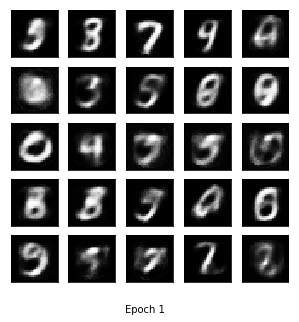

[2/100]: loss_vae: 24582.605


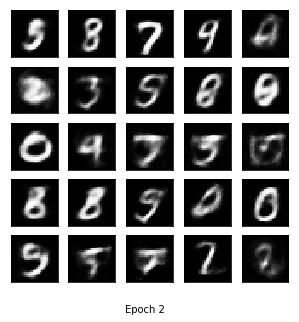

[3/100]: loss_vae: 22174.772


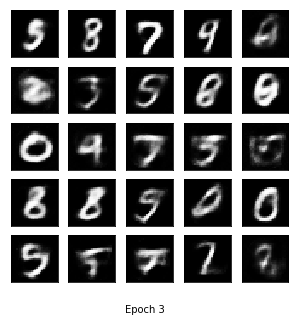

[4/100]: loss_vae: 21015.251


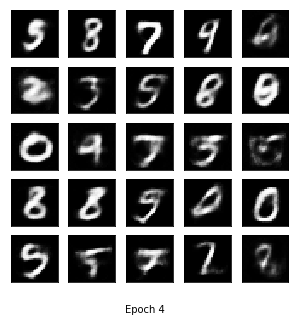

[5/100]: loss_vae: 20289.450


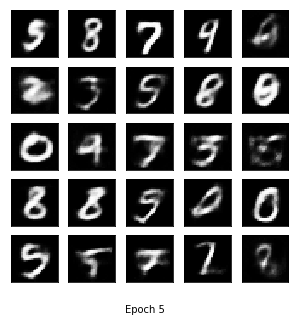

[6/100]: loss_vae: 19794.813


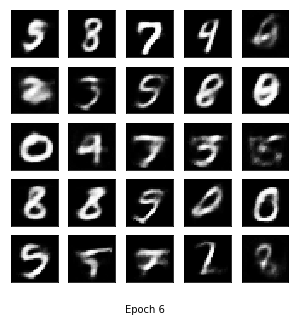

[7/100]: loss_vae: 19383.726


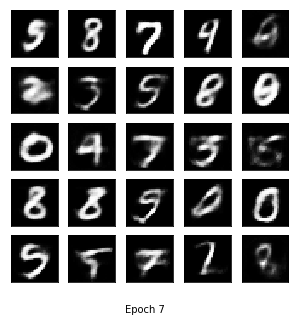

[8/100]: loss_vae: 19101.969


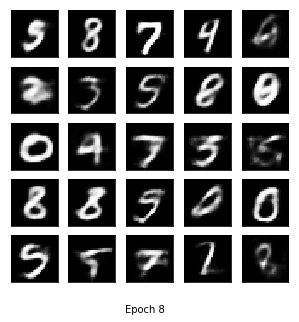

[9/100]: loss_vae: 18817.405


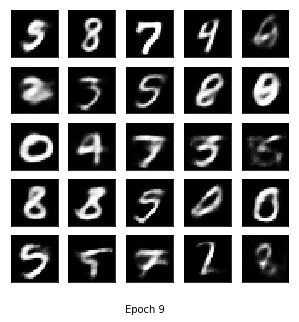

[10/100]: loss_vae: 18605.346


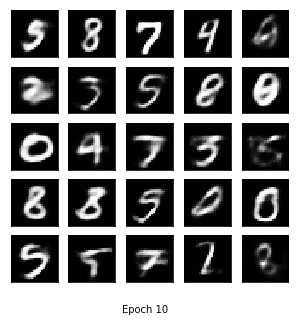

[11/100]: loss_vae: 18398.689


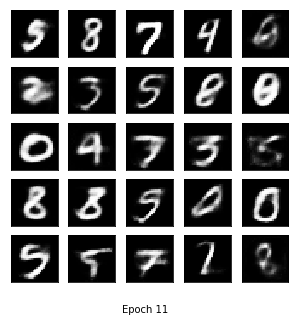

[12/100]: loss_vae: 18198.203


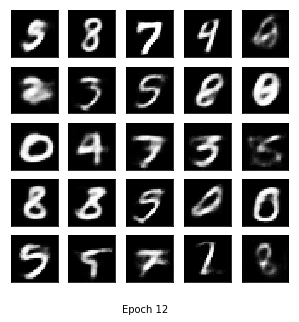

[13/100]: loss_vae: 18021.285


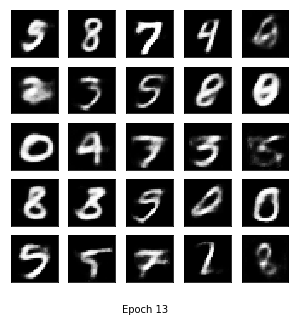

[14/100]: loss_vae: 17886.217


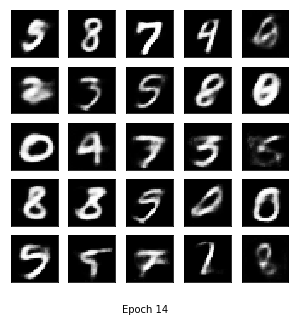

[15/100]: loss_vae: 17768.401


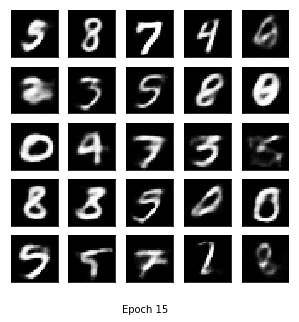

[16/100]: loss_vae: 17642.963


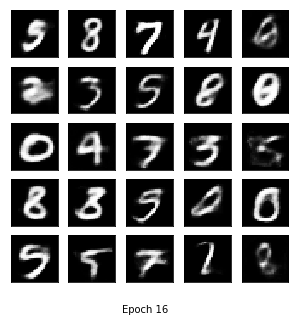

[17/100]: loss_vae: 17540.499


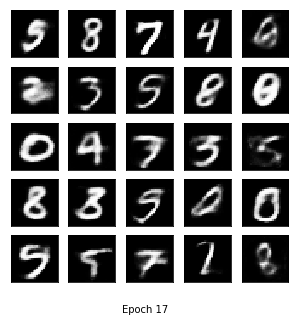

[18/100]: loss_vae: 17426.251


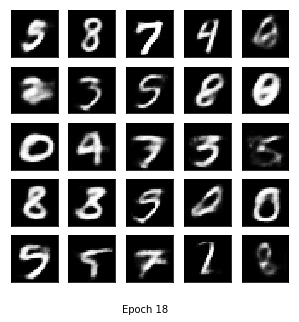

[19/100]: loss_vae: 17335.446


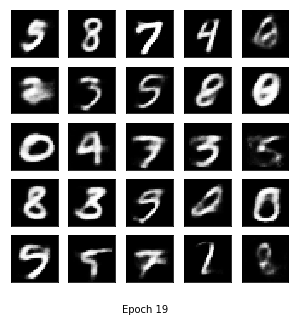

[20/100]: loss_vae: 17255.764


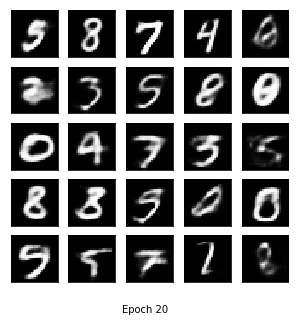

[21/100]: loss_vae: 17148.247


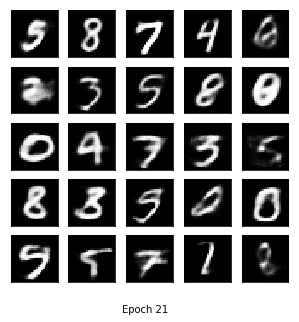

[22/100]: loss_vae: 17066.466


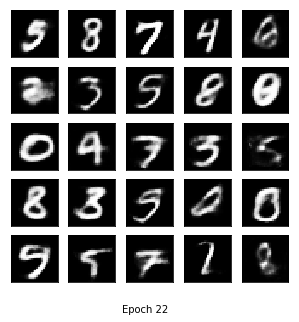

[23/100]: loss_vae: 17021.524


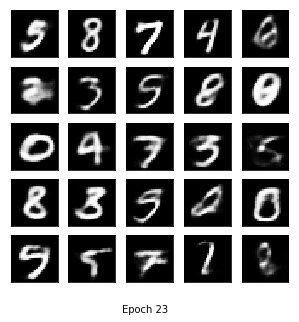

[24/100]: loss_vae: 16959.440


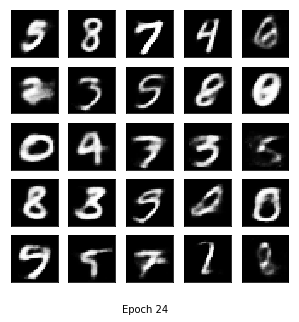

[25/100]: loss_vae: 16838.383


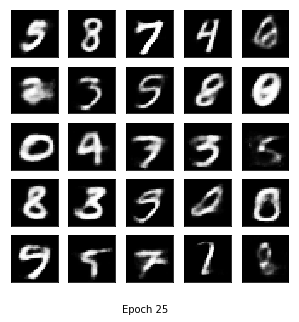

[26/100]: loss_vae: 16818.137


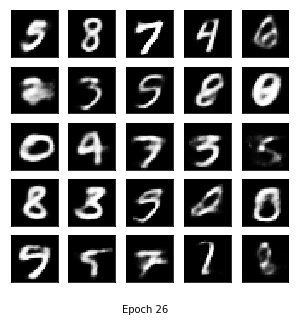

[27/100]: loss_vae: 16734.934


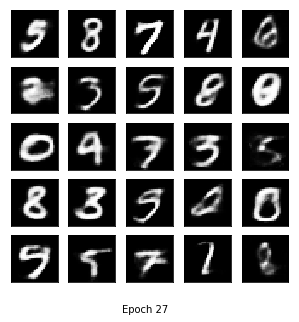

[28/100]: loss_vae: 16671.148


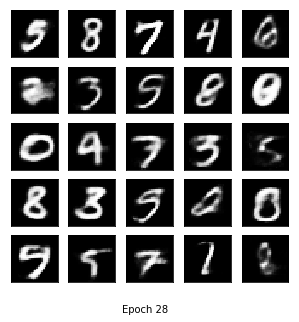

[29/100]: loss_vae: 16632.577


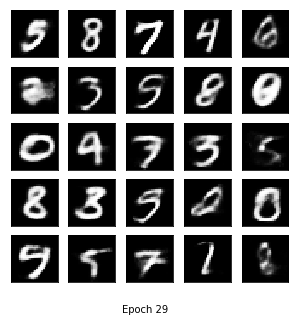

[30/100]: loss_vae: 16568.238


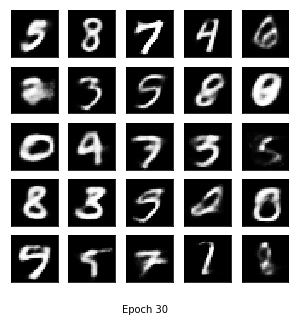

[31/100]: loss_vae: 16513.454


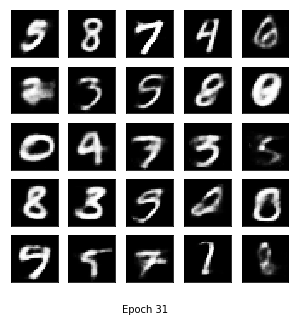

[32/100]: loss_vae: 16464.432


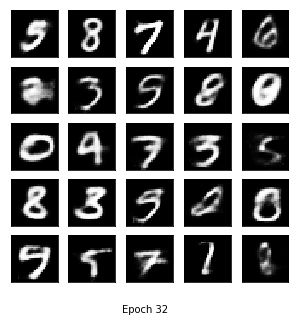

[33/100]: loss_vae: 16423.442


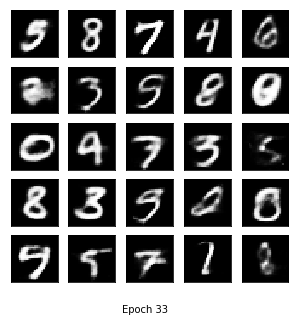

[34/100]: loss_vae: 16371.109


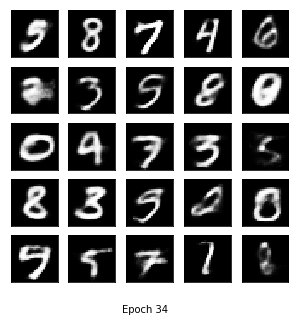

[35/100]: loss_vae: 16347.173


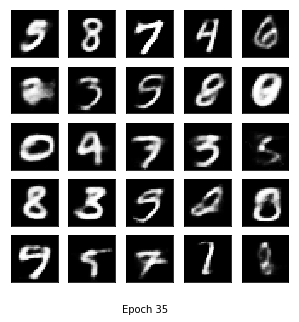

[36/100]: loss_vae: 16281.150


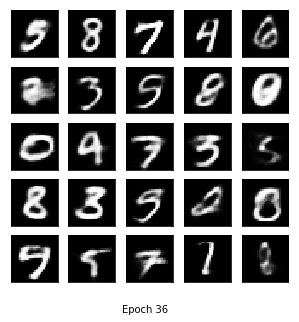

[37/100]: loss_vae: 16255.233


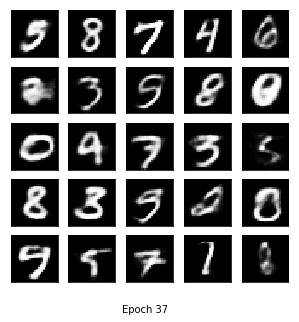

[38/100]: loss_vae: 16211.311


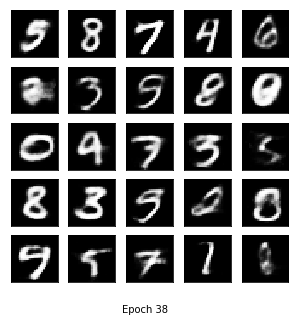

[39/100]: loss_vae: 16175.666


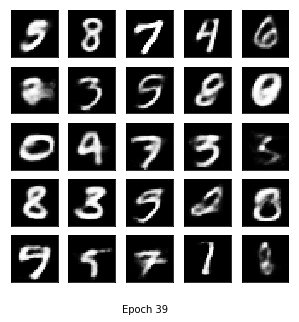

[40/100]: loss_vae: 16155.134


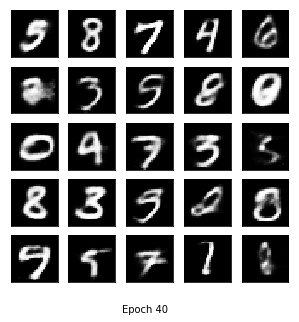

[41/100]: loss_vae: 16105.256


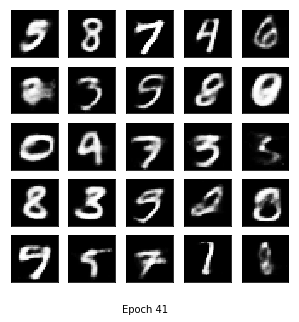

[42/100]: loss_vae: 16089.925


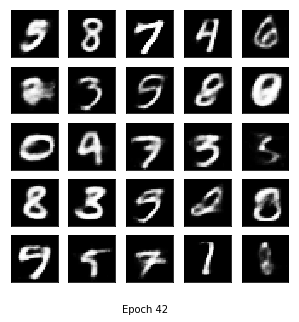

[43/100]: loss_vae: 16039.583


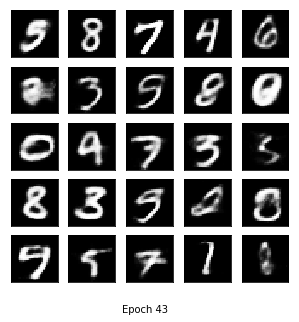

[44/100]: loss_vae: 16016.056


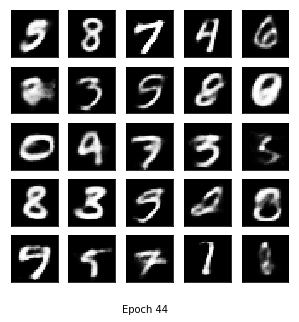

[45/100]: loss_vae: 15965.895


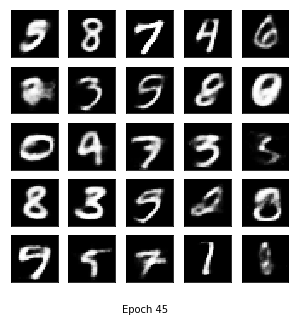

[46/100]: loss_vae: 15935.261


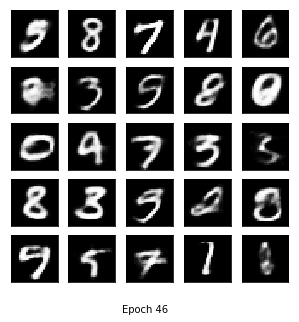

[47/100]: loss_vae: 15909.400


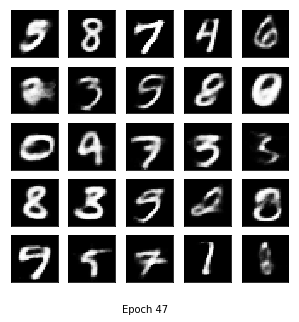

[48/100]: loss_vae: 15913.953


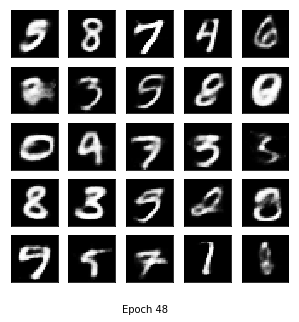

[49/100]: loss_vae: 15874.945


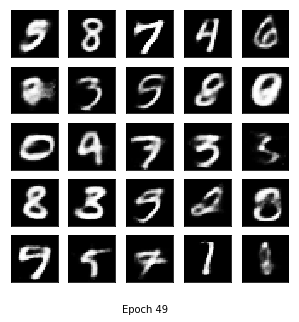

[50/100]: loss_vae: 15841.352


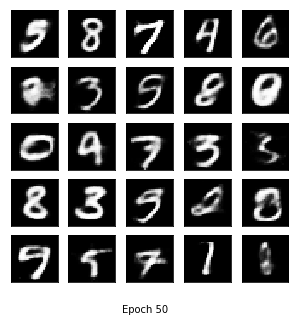

[51/100]: loss_vae: 15832.286


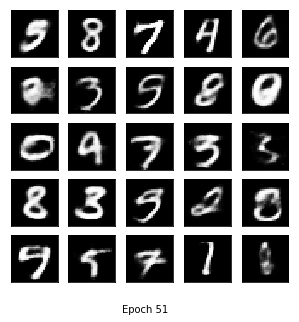

[52/100]: loss_vae: 15775.561


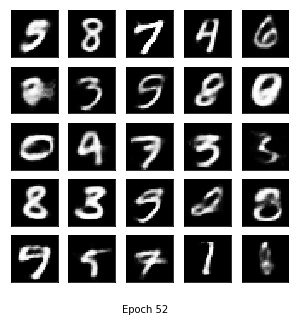

[53/100]: loss_vae: 15762.150


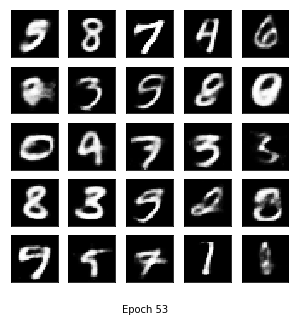

[54/100]: loss_vae: 15732.325


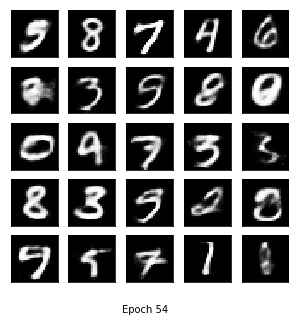

[55/100]: loss_vae: 15720.675


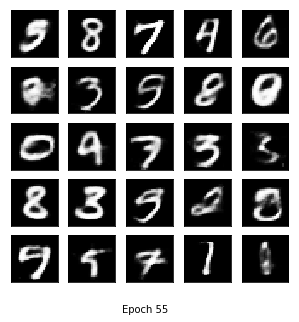

[56/100]: loss_vae: 15707.692


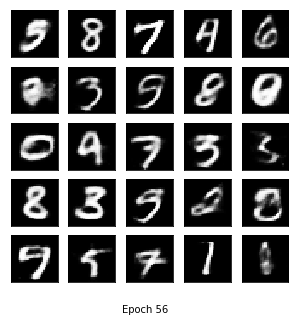

[57/100]: loss_vae: 15693.882


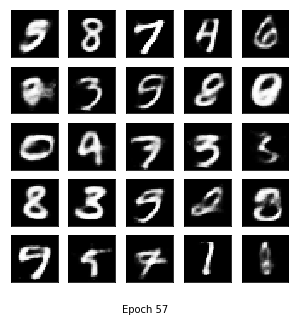

[58/100]: loss_vae: 15666.061


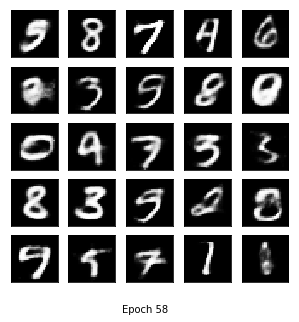

[59/100]: loss_vae: 15635.485


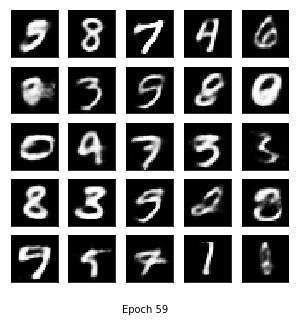

[60/100]: loss_vae: 15607.229


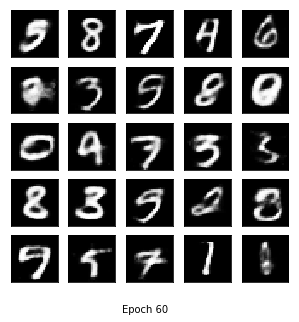

[61/100]: loss_vae: 15622.900


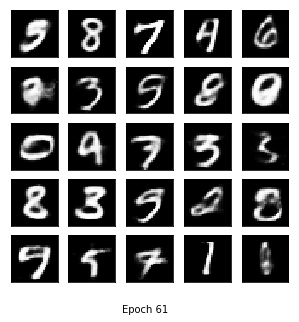

[62/100]: loss_vae: 15565.029


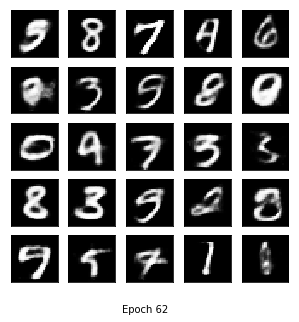

[63/100]: loss_vae: 15572.715


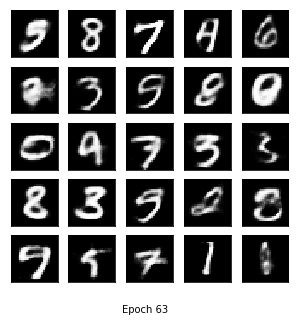

[64/100]: loss_vae: 15524.598


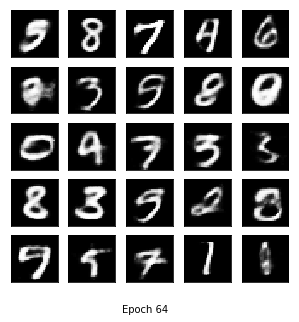

[65/100]: loss_vae: 15538.983


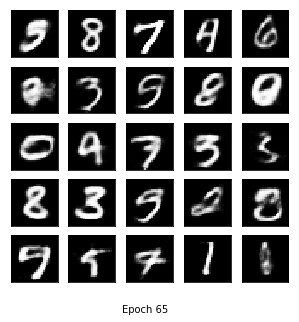

[66/100]: loss_vae: 15517.515


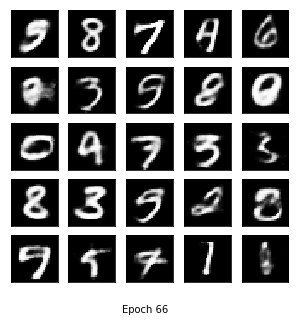

[67/100]: loss_vae: 15487.914


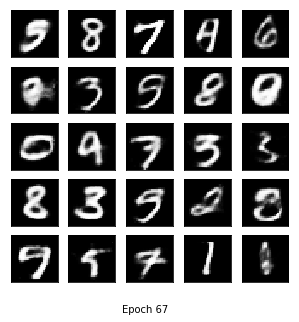

[68/100]: loss_vae: 15466.759


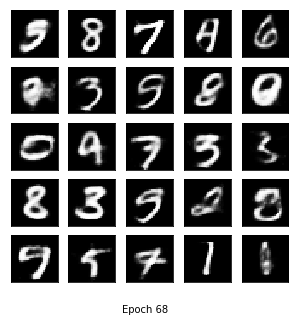

[69/100]: loss_vae: 15460.499


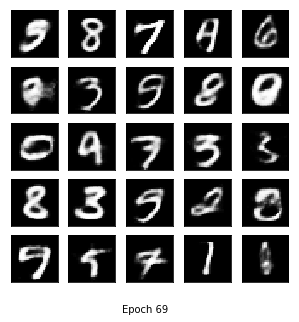

[70/100]: loss_vae: 15446.897


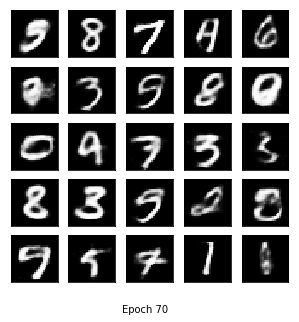

[71/100]: loss_vae: 15440.286


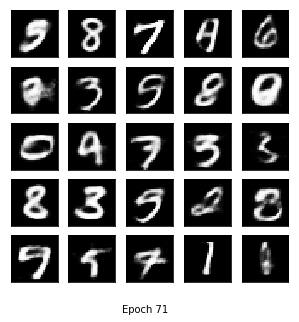

[72/100]: loss_vae: 15401.626


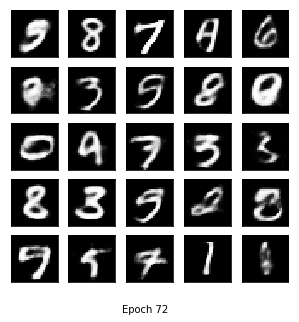

[73/100]: loss_vae: 15425.819


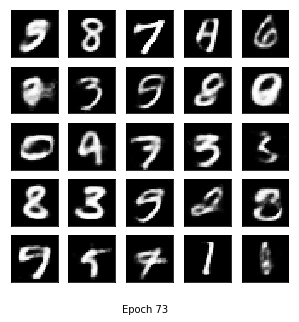

[74/100]: loss_vae: 15389.562


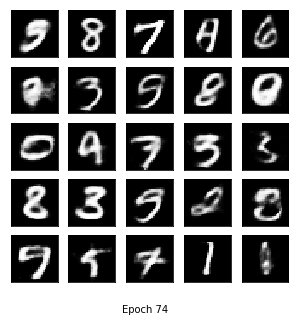

[75/100]: loss_vae: 15374.143


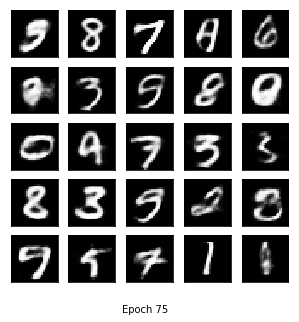

[76/100]: loss_vae: 15362.366


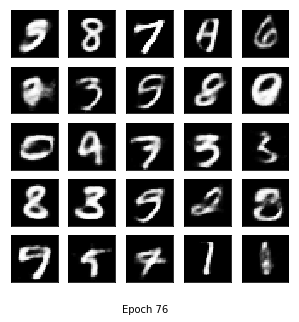

[77/100]: loss_vae: 15345.377


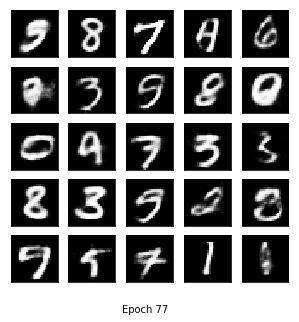

[78/100]: loss_vae: 15330.244


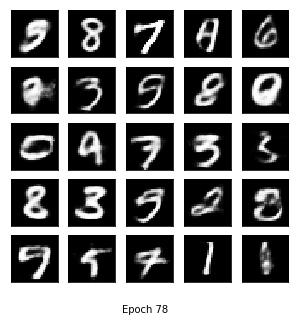

[79/100]: loss_vae: 15325.932


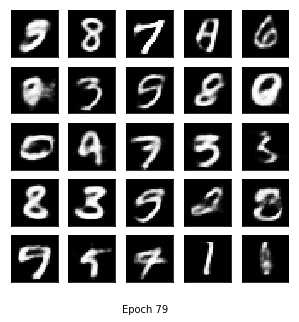

[80/100]: loss_vae: 15331.366


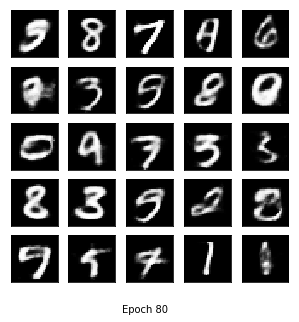

[81/100]: loss_vae: 15301.223


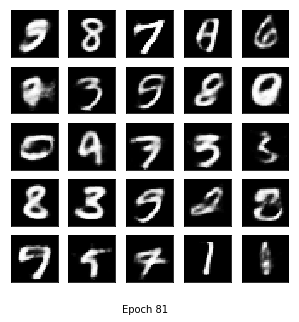

[82/100]: loss_vae: 15288.351


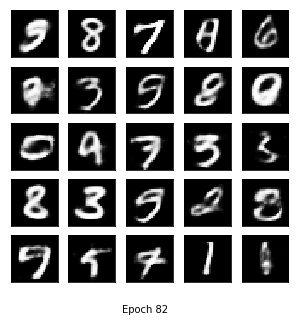

[83/100]: loss_vae: 15263.446


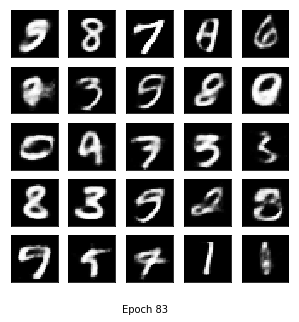

[84/100]: loss_vae: 15251.484


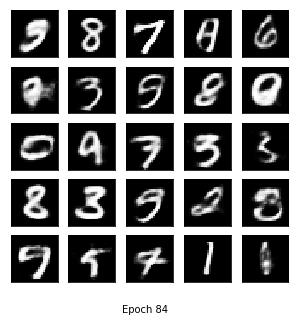

[85/100]: loss_vae: 15254.198


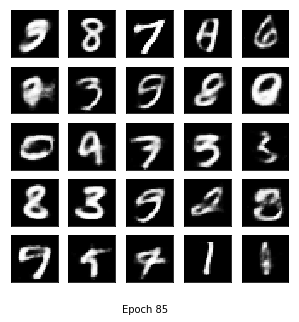

[86/100]: loss_vae: 15251.959


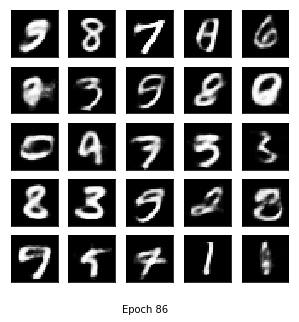

[87/100]: loss_vae: 15223.051


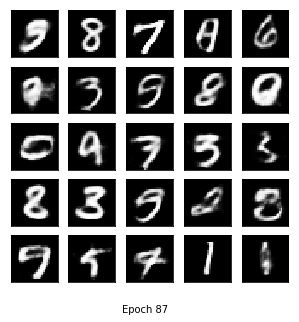

[88/100]: loss_vae: 15223.478


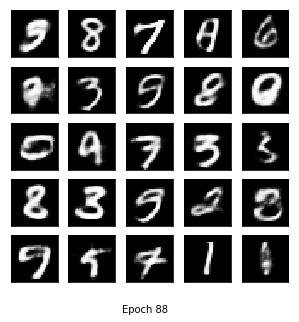

[89/100]: loss_vae: 15202.281


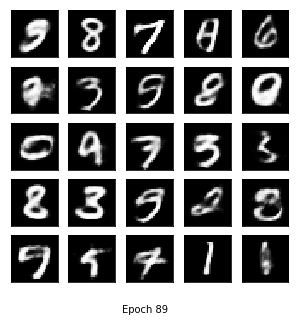

[90/100]: loss_vae: 15189.311


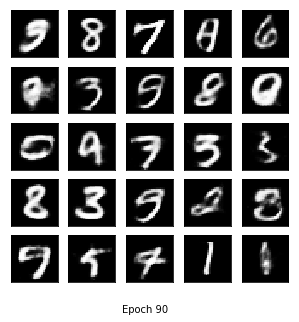

[91/100]: loss_vae: 15177.555


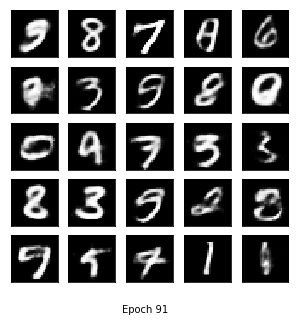

[92/100]: loss_vae: 15172.250


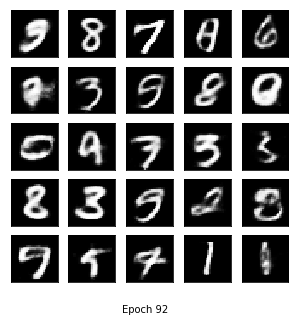

[93/100]: loss_vae: 15159.884


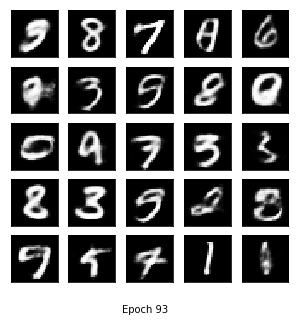

[94/100]: loss_vae: 15118.843


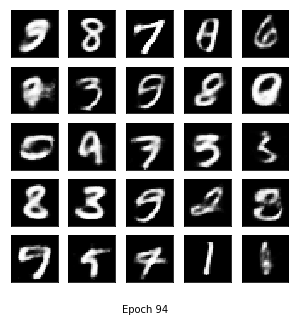

[95/100]: loss_vae: 15153.951


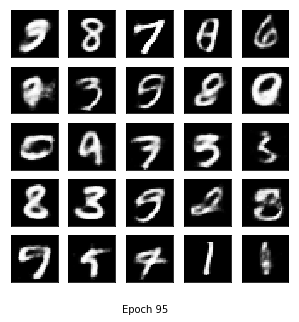

[96/100]: loss_vae: 15138.725


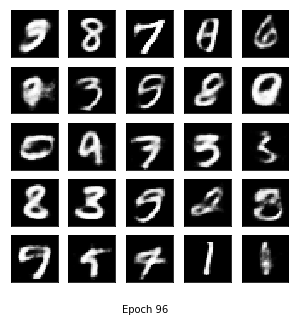

[97/100]: loss_vae: 15118.440


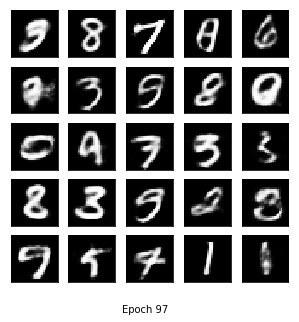

[98/100]: loss_vae: 15120.455


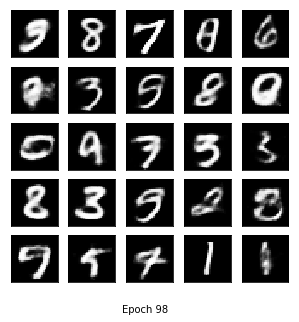

[99/100]: loss_vae: 15095.297


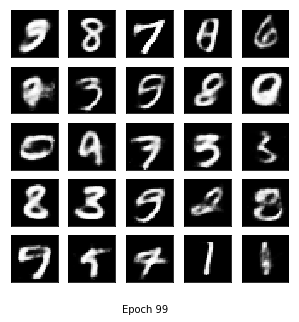

[100/100]: loss_vae: 15076.209


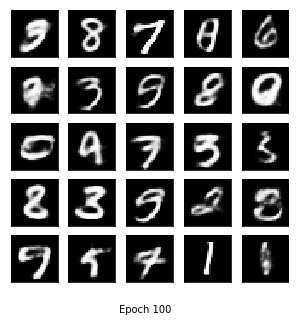

Training finish!... save training results


In [10]:
train_hist = {}
train_hist['VAE_losses'] = []

for epoch in range(train_epoch):
    VAE_losses = []

    for x, _ in train_loader:
        mini_batch = x.size()[0]

        x = x.view(-1, 28 * 28)
        
        model.zero_grad()

        x = Variable(x)
        x_reconstructed, mu, logvar = model(x)
        loss = loss_function(x_reconstructed, x, mu, logvar)
        loss.backward()
        optimizer.step()

        VAE_losses.append(loss.data[0])
        
    loss_mean = torch.mean(torch.FloatTensor(VAE_losses))
    print('[%d/%d]: loss_vae: %.3f' % ((epoch + 1), train_epoch, loss_mean))
    
    p = random_folder + '/MNIST_VAE_%03d.png' % (epoch+1)
    fixed_p = fixed_folder + '/MNIST_VAE_%03d.png' % (epoch+1)
    show_result((epoch+1), prior_size=prior_size, save=True, show=False, path=p, isFix=False)
    show_result((epoch+1), prior_size=prior_size, save=True, show=True, path=fixed_p, isFix=True)
    train_hist['VAE_losses'].append(loss_mean)

    
print("Training finish!... save training results")
torch.save(model.state_dict(), root_folder + '/modelparam.pkl')
